In [1]:
import pandas as pd
import numpy as np
from NEExT.NEExT import NEExT
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import xgboost
import random
import plotly.express as px
from scipy.stats import wasserstein_distance
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, precision_score, recall_score

In [2]:
def build_model(dataset_name, features):
    
    edge_file = "https://raw.githubusercontent.com/elmspace/ugaf_experiments_data/main/real_world_graphs/%s/processed_data/edge_file.csv"%(dataset_name)
    graph_label_file = "https://raw.githubusercontent.com/elmspace/ugaf_experiments_data/main/real_world_graphs/%s/processed_data/graph_label_mapping_file.csv"%(dataset_name)
    node_graph_mapping_file = "https://raw.githubusercontent.com/elmspace/ugaf_experiments_data/main/real_world_graphs/%s/processed_data/node_graph_mapping_file.csv"%(dataset_name)

    nxt = NEExT(quiet_mode="off")
    nxt.load_data_from_csv(edge_file=edge_file, node_graph_mapping_file=node_graph_mapping_file, graph_label_file=graph_label_file)

    for feats in features:
        nxt.compute_graph_feature(feat_name=feats[0], feat_vect_len=feats[1])
    
    nxt.pool_graph_features(pool_method="concat")

    nxt.build_graph_embedding(emb_dim_len=len(features), emb_engine="approx_wasserstein")
    nxt.build_classification_model(sample_size=30, balance_classes=False)

    return nxt.ml_model_results

In [3]:
# features = ["basic_expansion", "self_walk", "page_rank", "degree_centrality", "closeness_centrality", "load_centrality",
#            "eigenvector_centrality", "lsme"]

# Supervised

In [4]:
features = [
    ["page_rank", 0],
    ["load_centrality", 2],
    ["load_centrality", 3],
    ["self_walk", 3],
    ["load_centrality", 1]
]
supervised = build_model("NCI1", features)

Building models:: 100%|████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.35it/s]


# Unsupervised

In [5]:
features = [
    ["page_rank", 0],
    ["lsme", 1],
    ["page_rank", 1],
    ["degree_centrality", 0],
    ["degree_centrality", 1]
]
unsupervised = build_model("NCI1", features)

Building models:: 100%|████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.61it/s]


# Random

In [13]:
feature_set = ["basic_expansion", "self_walk", "page_rank", "degree_centrality", "closeness_centrality", "load_centrality", "eigenvector_centrality", "lsme"]
feat_len_set = [1, 2, 3, 4]
features = []
for i in range(5):
    feat_name = random.sample(feature_set, 1)[0]
    feat_len = random.sample(feat_len_set, 1)[0]
    features.append([feat_name, feat_len])
print(features)

[['closeness_centrality', 3], ['lsme', 3], ['basic_expansion', 2], ['load_centrality', 4], ['load_centrality', 1]]


In [14]:
random_model = build_model("NCI1", features)

Building models:: 100%|████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.24it/s]


# Analysis

In [15]:
df_supervised = pd.DataFrame()
df_supervised["Accuracy"] = supervised["accuracy"]
df_supervised["Method"] = "Supervised"

df_unsupervised = pd.DataFrame()
df_unsupervised["Accuracy"] = unsupervised["accuracy"]
df_unsupervised["Method"] = "Unsupervised"

df_random = pd.DataFrame()
df_random["Accuracy"] = random_model["accuracy"]
df_random["Method"] = "Random"

In [16]:
results = pd.concat([df_supervised, df_unsupervised, df_random])

In [17]:
results.head()

,Accuracy,Method
0,0.645580,Supervised
1,0.658556,Supervised
2,0.638281,Supervised
3,0.649635,Supervised
4,0.630981,Supervised


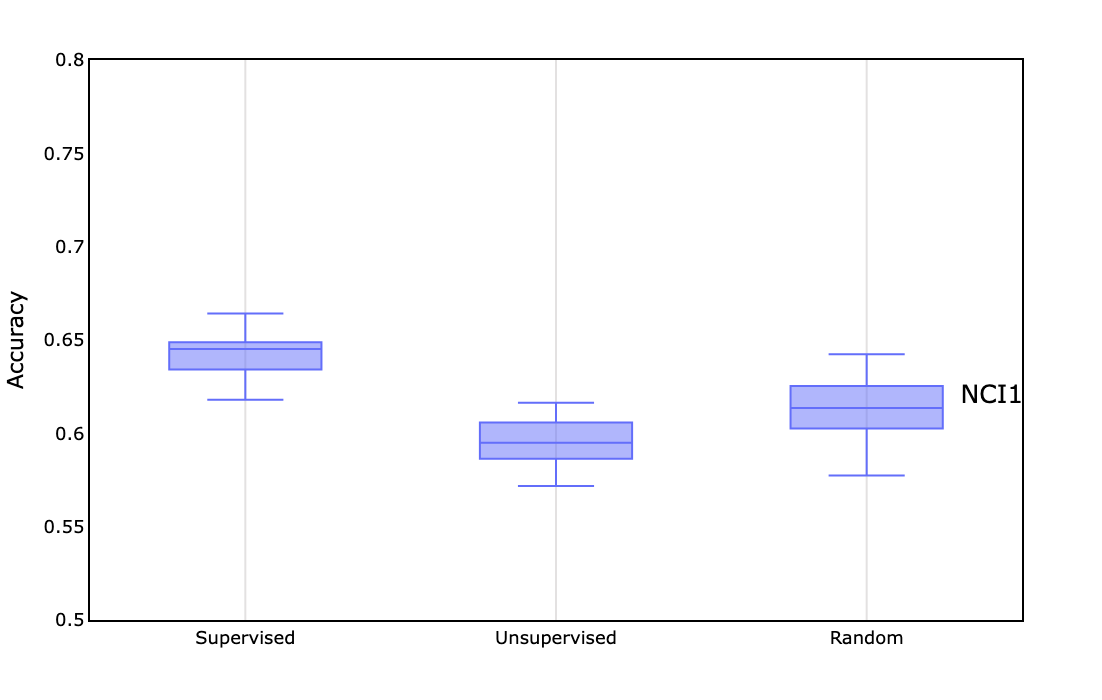

In [18]:
fig = px.box(results, x="Method", y="Accuracy")


fig.update_layout(paper_bgcolor='white')
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(color='black')
fig.update_layout(
    yaxis = dict(
        title = "Accuracy",
        zeroline=True,
        showline = True,
        linecolor = 'black',
        mirror=True,
        linewidth = 2
    ),
    xaxis = dict(
        title = "",
        mirror=True,
        zeroline=True,
        showline = True,
        linecolor = 'black',
        linewidth = 2,
    ),
    width=1150,
    height=700,
    font=dict(
    size=18,
    color="black")  
)
fig.update_layout(title={'text':'NCI1', 'y':0.45, 'x':0.9,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(showlegend=False)
fig.update_layout(yaxis_range=[0.5,0.8])
fig.update_xaxes(showgrid=True, gridwidth=2.0, gridcolor='#e3e1e1')
fig.update_yaxes(showgrid=False, gridwidth=0.5, gridcolor='grey')
fig.update_traces(marker_line_color='black', marker_line_width=1.0, opacity=1.0)


fig.show()